In [3]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


https://scipython.com/book2/chapter-4-the-core-python-language-ii/examples/a-simple-2d-molecular-dynamics-simulation/

In [5]:
import math

class Vector2D:
    """A two-dimensional vector with Cartesian coordinates."""

    def __init__(self, x, y):
        self.x, self.y = x, y

    def __str__(self):
        """Human-readable string representation of the vector."""
        return '{:g}i + {:g}j'.format(self.x, self.y)

    def __repr__(self):
        """Unambiguous string representation of the vector."""
        return repr((self.x, self.y))

    def dot(self, other):
        """The scalar (dot) product of self and other. Both must be vectors."""

        if not isinstance(other, Vector2D):
            raise TypeError('Can only take dot product of two Vector2D objects')
        return self.x * other.x + self.y * other.y
    # Alias the __matmul__ method to dot so we can use a @ b as well as a.dot(b).
    __matmul__ = dot

    def __sub__(self, other):
        """Vector subtraction."""
        return Vector2D(self.x - other.x, self.y - other.y)

    def __add__(self, other):
        """Vector addition."""
        return Vector2D(self.x + other.x, self.y + other.y)

    def __mul__(self, scalar):
        """Multiplication of a vector by a scalar."""

        if isinstance(scalar, int) or isinstance(scalar, float):
            return Vector2D(self.x*scalar, self.y*scalar)
        raise NotImplementedError('Can only multiply Vector2D by a scalar')

    def __rmul__(self, scalar):
        """Reflected multiplication so vector * scalar also works."""
        return self.__mul__(scalar)

    def __neg__(self):
        """Negation of the vector (invert through origin.)"""
        return Vector2D(-self.x, -self.y)

    def __truediv__(self, scalar):
        """True division of the vector by a scalar."""
        return Vector2D(self.x / scalar, self.y / scalar)

    def __mod__(self, scalar):
        """One way to implement modulus operation: for each component."""
        return Vector2D(self.x % scalar, self.y % scalar)

    def __abs__(self):
        """Absolute value (magnitude) of the vector."""
        return math.sqrt(self.x**2 + self.y**2)

    def distance_to(self, other):
        """The distance between vectors self and other."""
        return abs(self - other)

    def to_polar(self):
        """Return the vector's components in polar coordinates."""
        return self.__abs__(), math.atan2(self.y, self.x)

ncollisions = 155


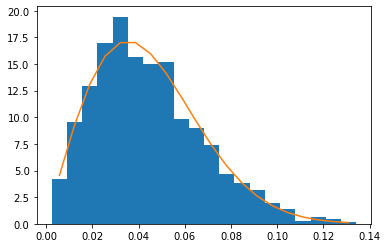

In [12]:
import math
import random
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
#from vector2d import Vector2D

class Particle:
    """A circular particle of unit mass with position and velocity."""

    def __init__(self, x, y, vx, vy, radius=0.01):
        self.pos = Vector2D(x, y)
        self.vel = Vector2D(vx, vy)
        self.radius = radius

    def advance(self, dt):
        """Advance the particle's position according to its velocity."""

        # Use periodic boundary conditions: a Particle that moves across an
        # edge of the domain 0<=x<1, 0<=y<1 magically reappears at the opposite
        # edge.
        self.pos = (self.pos + self.vel * dt) % 1

    def distance_to(self, other):
        """Return the distance from this Particle to other Particle."""
        return self.pos.distance_to(other.pos)

    def get_speed(self):
        """Return the speed of the Particle from its velocity."""
        return abs(self.vel)


class Simulation:
    """A simple simulation of circular particles in motion."""

    def __init__(self, nparticles=100, radius=0.01, v0=0.05):
        self.nparticles = nparticles
        self.radius = radius
        # Randomly initialize the particles' positions and velocity directions.
        self.particles = [self.init_particle(v0) for i in range(nparticles)]
        self.t = 0

    def init_particle(self, v0=0.05):
        """Return a new Particle object with random position and velocity.

        The position is chosen uniformly from 0 <= x < 1, 0 <= y < 1;
        The velocity has fixed magnitude, v0, but random direction.

        """

        x, y = random.random(), random.random()
        theta = 2*math.pi * random.random()
        self.v0 = v0
        vx, vy = self.v0 * math.cos(theta), self.v0 * math.sin(theta)
        return Particle(x, y, vx, vy, self.radius)

    def advance(self, dt):
        """Advance the Simulation by dt in time, handling collisions."""

        self.t += dt
        for particle in self.particles:
            particle.advance(dt)

        # Find all distinct pairs of Particles currently undergoing a collision.
        colliding_pair = []
        for i in range(self.nparticles):
            pi = self.particles[i]
            for j in range(i+1, self.nparticles):
                pj = self.particles[j]
                # pi collides with pj if their separation is less than twice
                # their radius.
                if pi.distance_to(pj) < 2 * self.radius:
                    colliding_pair.append((i, j))

        print('ncollisions =', len(colliding_pair),end='\r')
        # For each pair, the velocities change according to the kinetics of
        # an elastic collision between circles.
        for i,j in colliding_pair:
            p1, p2 = self.particles[i], self.particles[j]
            r1, r2 = p1.pos, p2.pos
            v1, v2 = p1.vel, p2.vel
            dr, dv = r2 - r1, v2 - v1
            dv_dot_dr = dv.dot(dr)
            d = r1.distance_to(r2) ** 2
            p1.vel = v1 - dv_dot_dr / d * (r1 - r2)
            p2.vel = v2 - dv_dot_dr / d * (r2 - r1)

if __name__ == '__main__':
    import numpy as np

    sim = Simulation(nparticles=1000, radius=0.005, v0=0.05)
    dt = 0.02

    nit = 500
    dnit = nit // 10
    for i in tqdm(range(nit)):
        if not i % dnit:
            print(f'{i}/{nit}',end='\r')
        sim.advance(dt)

    # Plot a histogram of the Particles' speeds.
    nbins = sim.nparticles // 50
    hist, bins, _ = plt.hist([p.get_speed() for p in sim.particles], nbins,
                          density=True)
    v = (bins[1:] + bins[:-1])/2

    # The mean kinetic energy per Particle.
    KE = sim.v0**2 / 2
    # The Maxwell-Boltzmann equilibrium distribution of speeds.
    a = 1 / 2 / KE
    f = 2*a * v * np.exp(-a*v**2)
    plt.plot(v, f)

    plt.show()

# Ideal gas simulations in a box

In [2]:
import prody

ModuleNotFoundError: No module named 'prody'

In [117]:
import nglview as nv

In [118]:
view = nv.show_structure_file('1PKN.pdb')

In [119]:
view

NGLWidget()

In [120]:
import MDAnalysis

In [121]:
u=MDAnalysis.Universe('1PKN.pdb')

In [122]:
s=u.select_atoms('all')

In [123]:
nv.show_mdanalysis(s)

NGLWidget()

In [124]:
import prody

In [125]:
pkn = prody.parsePDB('1PKN.pdb')

@> 3937 atoms and 1 coordinate set(s) were parsed in 0.05s.


In [126]:
nv.show_prody(pkn)

NGLWidget()

## Extract and analyze atom coordinates

#### Let's extract positions of C-alpha atoms in MDAnalysis

In [127]:
s=u.select_atoms('protein and name CA')

In [134]:
s.residues.atoms.names

array(['N', 'CA', 'C', ..., 'CG', 'CD', 'OXT'], dtype=object)

In [139]:
s.atoms.positions

array([[66.381, 47.66 , 51.52 ],
       [63.37 , 45.878, 52.463],
       [60.759, 44.413, 50.245],
       ...,
       [56.635, 26.235, 58.766],
       [57.039, 25.161, 55.154],
       [58.576, 21.693, 54.704]], dtype=float32)

#### Let's make a histogram of Calpha distances

In [136]:
import numpy as np

In [138]:
c[1:]

array([[63.37 , 45.878, 52.463],
       [60.759, 44.413, 50.245],
       [57.002, 44.603, 49.837],
       ...,
       [56.635, 26.235, 58.766],
       [57.039, 25.161, 55.154],
       [58.576, 21.693, 54.704]], dtype=float32)

In [144]:
c=s.atoms.positions
dvec=c[1:]-c[0:-1]
d=np.sqrt(dvec[:,0]**2+dvec[:,1]**2+dvec[:,2]**2)
#d=np.array([np.sqrt(i[0]**2+i[1]**2+i[2]**2) for i in dvec])

In [145]:
import seaborn as sns

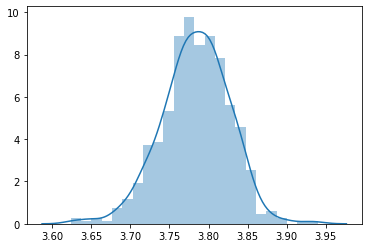

In [148]:
sns.distplot(d[d<5])

In [149]:
s.radius_of_gyration()

24.25554730915232

## Extract and analyze dihedral (torsion) angles

In [153]:
from MDAnalysis.analysis.dihedrals import Dihedral

In [154]:
r=u.residues[1]

In [155]:
r.phi_selection().names

array(['C', 'N', 'CA', 'C'], dtype=object)

In [156]:
dih=Dihedral([r.phi_selection()])

In [ ]:
dih.

In [157]:
dih.run()

In [ ]:
dih.

In [158]:
dih.angles

array([[-67.78035238]])

In [159]:
from MDAnalysis.analysis.dihedrals import Ramachandran

In [160]:
R=Ramachandran(s)

In [161]:
R.run()

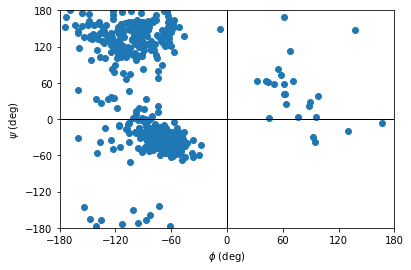

In [162]:
R.plot()

### Add hydrogens to the structure

In [164]:
!reduce 1PKN.pdb >1PKN_H.pdb

reduce: version 3.3 06/02/2016, Copyright 1997-2016, J. Michael Word
Processing file: "1PKN.pdb"
Database of HETATM connections: "/opt/miniconda3/envs/moldyn/dat/reduce_wwPDB_het_dict.txt"
VDW dot density = 16/A^2
Orientation penalty scale = 1 (100%)
Eliminate contacts within 3 bonds.
Ignore atoms with |occupancy| <= 0.01 during adjustments.
Waters ignored if B-Factor >= 40 or |occupancy| < 0.66
Aromatic rings in amino acids accept hydrogen bonds.
Building or keeping OH & SH Hydrogens.
Rotating NH3 Hydrogens.
Not processing Met methyls.
*WARNING*: Residues SER 126  and GLU 132  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues SER 126  and GLU 132  in chain  A appear unbonded 
            and will be treated as a chain break
 Singles(size 92): A  14 THR OG1 : A  24 THR OG1 : A  30 CYS SG  : A  36 SER OG  
  : A  40 THR OG1 : A  44 THR OG1 : A  48 CYS SG  : A  49 THR OG1 : A  54 SER OG  
  : A  61 LYS NZ  : A  65 LYS NZ  : A  66 SER OG  : 

### Identify protonation states

In [165]:
!propka 1PKN.pdb

propka3.0, revision 182                                                                      2021-03-01
-------------------------------------------------------------------------------------------------------
--                                                                                                   --
--                                   PROPKA: A PROTEIN PKA PREDICTOR                                 --
--                                                                                                   --
--                                VERSION 1.0,  04/25/2004, IOWA CITY                                --
--                                             BY HUI LI                                             --
--                                                                                                   --
--                               VERSION 2.0,  11/05/2007, IOWA CITY/COPENHAGEN                      --
--                                BY DELPHINE C. BAS AND DAVID M

In [166]:
!cat 1PKN.pka

propka3.0, revision 182                                                                      2021-03-01
-------------------------------------------------------------------------------------------------------
--                                                                                                   --
--                                   PROPKA: A PROTEIN PKA PREDICTOR                                 --
--                                                                                                   --
--                                VERSION 1.0,  04/25/2004, IOWA CITY                                --
--                                             BY HUI LI                                             --
--                                                                                                   --
--                               VERSION 2.0,  11/05/2007, IOWA CITY/COPENHAGEN                      --
--                                BY DELPHINE C. BAS AND DAVID M

#### assign charges to the atoms

In [167]:
!pdb2pqr 1PKN.pdb 1PKN.pqr --ff amber


--------------------------
PDB2PQR - a Python-based structural conversion utility
--------------------------
Please cite your use of PDB2PQR as:
  Dolinsky TJ, Nielsen JE, McCammon JA, Baker NA.
  PDB2PQR: an automated pipeline for the setup, execution,
  and analysis of Poisson-Boltzmann electrostatics calculations.
  Nucleic Acids Research 32 W665-W667 (2004).



In [168]:
!cat 1PKN.pqr

REMARK   1 PQR file generated by PDB2PQR (Version FIXME)
REMARK   1
REMARK   1 Command line used to generate this file:
REMARK   1 1PKN.pdb 1PKN.pqr --ff amber
REMARK   1
REMARK   1 Forcefield Used: AMBER
REMARK   1
REMARK   5 Gap in backbone detected between SER A 126 and GLU A 132!
REMARK   5
REMARK   5 WARNING: PDB2PQR was unable to assign charges
REMARK   5          to the following atoms (omitted below):
REMARK   5              3931 K in K 532
REMARK   5              3932 MN in MN 534
REMARK   5              3933 C1 in PYR 533
REMARK   5              3934 O1 in PYR 533
REMARK   5              3935 O2 in PYR 533
REMARK   5              3936 C2 in PYR 533
REMARK   5              3937 O3 in PYR 533
REMARK   5              3938 C3 in PYR 533
REMARK   5 This is usually due to the fact that this residue is not
REMARK   5 an amino acid or nucleic acid; or, there are no parameters
REMARK   5 available for the specific protonation state of this
REMARK   5 residue in the selected forcefield

### build contact maps

In [169]:
c

array([[66.381, 47.66 , 51.52 ],
       [63.37 , 45.878, 52.463],
       [60.759, 44.413, 50.245],
       ...,
       [56.635, 26.235, 58.766],
       [57.039, 25.161, 55.154],
       [58.576, 21.693, 54.704]], dtype=float32)

In [88]:
from scipy.spatial.distance import pdist,squareform

In [170]:
dm=squareform(pdist(c))

In [171]:
dm.shape

(514, 514)

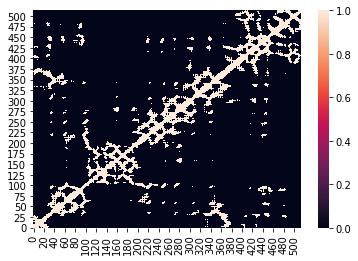

In [176]:
ax = sns.heatmap(np.where(dm<15,1,0))
ax.invert_yaxis()

### Analyze dynamics using elastic networks models with ProDy

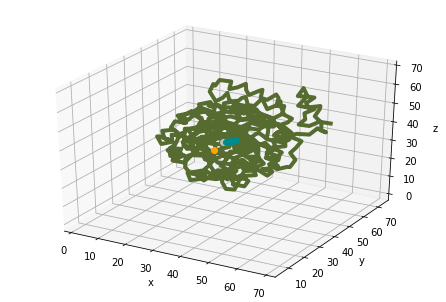

In [177]:
prody.showProtein(pkn)

In [178]:
prot=pkn.select('protein')

In [179]:
 anm, atoms = prody.calcANM(prot, selstr='calpha')

@> Hessian was built in 0.29s.
@> 20 modes were calculated in 0.30s.


In [180]:
slowest_mode = anm[0]

In [181]:
print( slowest_mode )

Mode 1 from ANM 1PKN


In [182]:
print( slowest_mode.getEigval().round(3) )

0.162


In [183]:
prody.writeNMD('1pkn.nmd',anm[:3],atoms)

'1pkn.nmd'

the file can be opened in VMD using normal mode wizard